# Overview

In this notebook, we utilize the visualization tools implemented in `pyramidkv/viztools` to replicate attention pattern observation experiments in a series of previous works.

We use one ***multi-doc QA*** example used for visualization in PyramidKV paper as sample input, and default to use ***meta-llama/Llama-3.2-3B-Instruct*** for inference.

You should run the code in [**0. setup**](#setup) before running attention observation experiments to import necessary dependencies and intialize the model.

##### 0. [Setup](#setup)
##### 1. [PyramidKV](#pyramidkv)
##### 2. [StreamingLLM](#streamingllm)
##### 3. [Scissorhands](#scissorhands)
<!-- ##### 4. [SnapKV](#snapkv) -->

# DEV setup

In [ ]:
import os
import sys
import random
import torch
sys.path.append(os.path.abspath("../"))
from pyramidkv.viztools import (
    infer_attention,
    plot_attention_heatmaps,
    plot_heatmap,
    attn_mp
)

attentions = torch.load("../attention/attention_outputs.pt")

# Setup

In [ ]:
import os
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys
sys.path.append(os.path.abspath("../"))
from pyramidkv.viztools import (
    infer_attention,
    plot_attention_heatmaps,
    plot_heatmap,
    attn_mp
)

# load the model and tokenizer
MODEL_NAME_OR_PATH = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME_OR_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the sample input
with open("../pyramidkv/viztools/test_input.txt", 'r') as file:
    prompt = file.read().strip()

attentions = infer_attention(model, tokenizer, device)

# PyramidKV

Attention heatmap saved to ../obs/pyramidkv/layer0.jpg


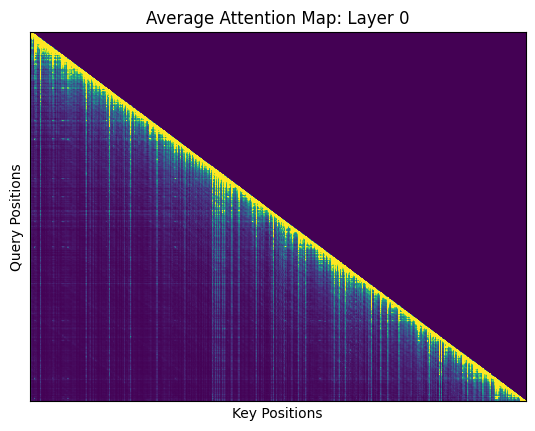

Attention heatmap saved to ../obs/pyramidkv/layer13.jpg


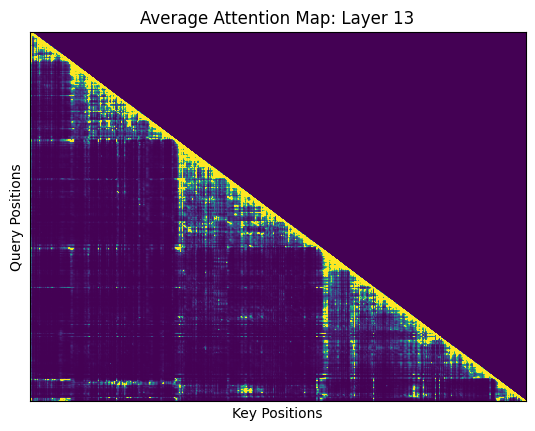

Attention heatmap saved to ../obs/pyramidkv/layer27.jpg


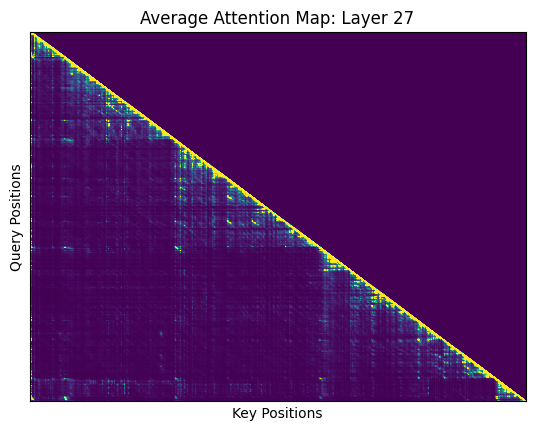

Attention heatmap saved to ../obs/pyramidkv/layer10_head3.jpg


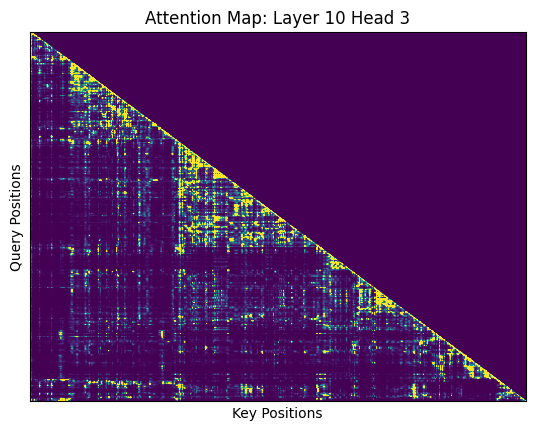

In [6]:
plot_attention_heatmaps(
    attentions,
    map_fn=lambda x: x * 10000,
    layer_ids=[0, 13, 27],
    save_dir="pyramidkv"
)

plot_attention_heatmaps(
    attentions,
    map_fn=lambda x: x * 10000,
    layer_ids=[10],
    head_ids=[3],
    save_dir="pyramidkv"
)

# StreamingLLM

We follow StreamingLLM to truncate input length to 16 tokens to better visualize the attention sink phenomenon.

Attention heatmap saved to ../obs/streamingllm/layer0_head0.png


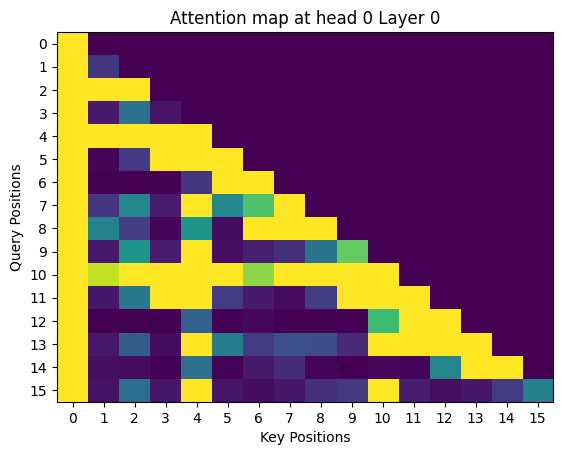

Attention heatmap saved to ../obs/streamingllm/layer4_head0.png


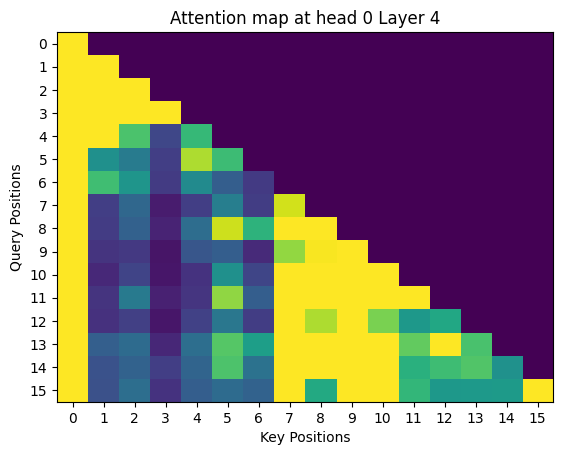

Attention heatmap saved to ../obs/streamingllm/layer7_head0.png


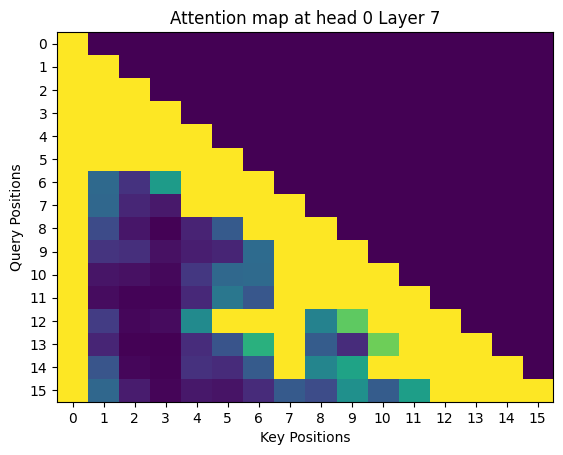

Attention heatmap saved to ../obs/streamingllm/layer25_head0.png


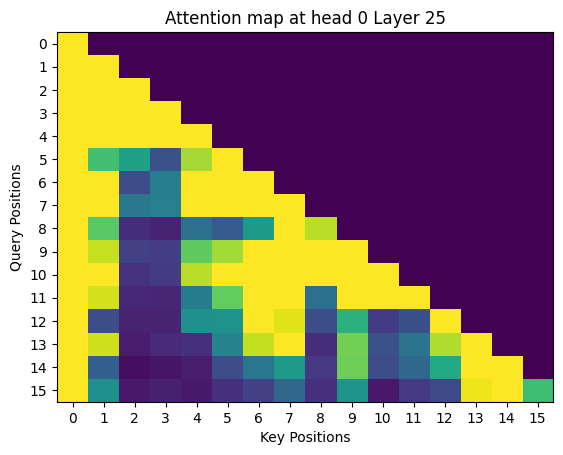

In [18]:
num_layers = len(attentions)
layer_idx = sorted(random.sample(range(num_layers), k=4))
head_idx = 0

for layer in layer_idx:
    data = attentions[layer][head_idx, :16, :16] * 10000
    plot_heatmap(
        data,
        title=f"Attention map at head {head_idx} Layer {layer}",
        show_ticks=True,
        save_path=f"../obs/streamingllm/layer{layer}_head{head_idx}.png"
    )

# Scissorhands

Attention heatmap saved to ../obs/scissorhands/layer5_position223.png


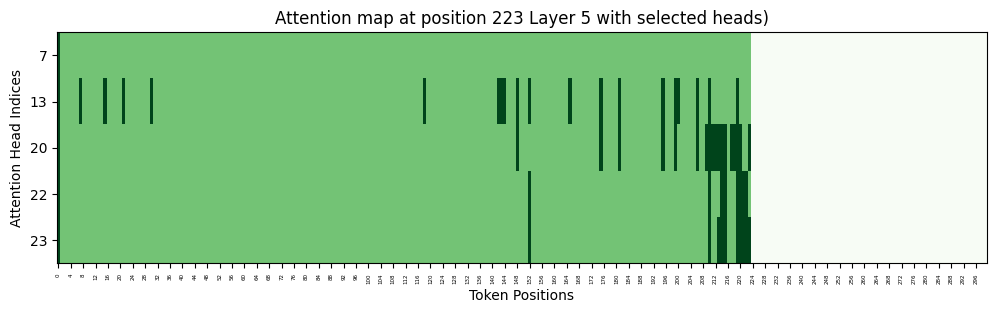

Attention heatmap saved to ../obs/scissorhands/layer5_position263.png


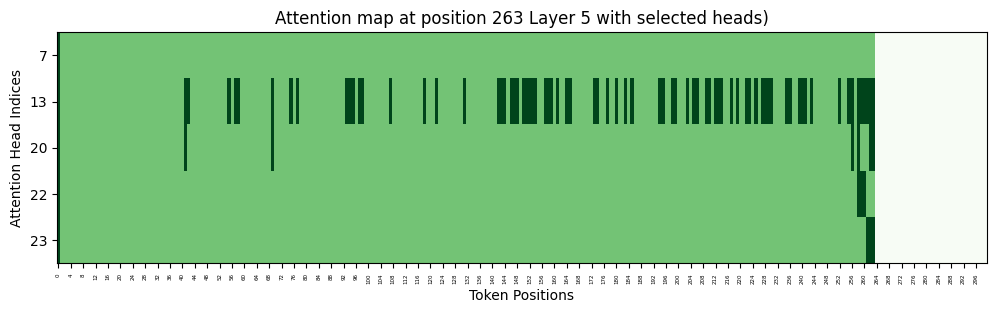

Attention heatmap saved to ../obs/scissorhands/layer5_position285.png


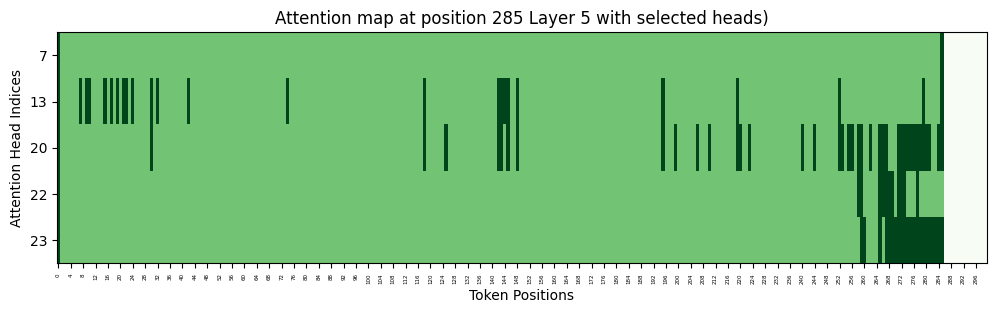

Attention heatmap saved to ../obs/scissorhands/layer5_position287.png


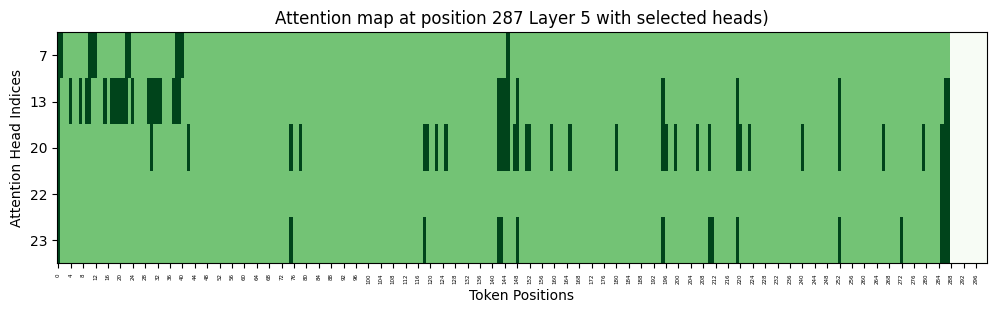

In [17]:
# Select random position, heads and layers
num_layers = len(attentions)
random_layer = random.randint(0, num_layers - 1)

num_heads = attentions[0].size(0)
seq_len = attentions[0].size(1)

random_heads = sorted(random.sample(range(num_heads), k=min(5, num_heads)))  # Select up to 4 random heads
random_pos_lst = random.sample(range(200, min(seq_len, 300)), k=4)  # Select 4 random positions before 300 for better visualization

for rand_pos in sorted(random_pos_lst):
    data = attentions[random_layer][random_heads, rand_pos, :min(seq_len, 300)]
    data = attn_mp(data)
    plot_heatmap(
        data,
        title=f"Attention map at position {rand_pos} Layer {random_layer} with selected heads)",
        fig_size=(12, 3),
        x_label="Token Positions",
        y_label="Attention Head Indices",
        show_ticks=True,
        y_ticks=random_heads,
        cmap="Greens",
        save_path=f"../obs/scissorhands/layer{random_layer}_position{rand_pos}.png"
    )